# Make oversampled PSF FITS files

Isaac Cheng - August 2023

NOTE: this notebook should not be necessary for most ETC use cases. It's just a reference
in case you would like to create an oversampled PSF yourself

In [1]:
from os.path import join

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from IPython.display import display
from scipy.interpolate import RegularGridInterpolator  # interp2d is deprecated

from castor_etc.filepaths import DATAPATH
from castor_etc.telescope import Telescope

# Make our own matplotlib colormap to mimic the "heat" map in DS9, because we're extra
# Based on: <https://gist.github.com/adonath/c9a97d2f2d964ae7b9eb>
from matplotlib.colors import LinearSegmentedColormap, LogNorm

ds9heat = {
    "red": lambda v: np.interp(v, [0, 0.34, 1], [0, 1, 1]),
    "green": lambda v: np.interp(v, [0, 1], [0, 1]),
    "blue": lambda v: np.interp(v, [0, 0.65, 0.98, 1], [0, 0, 1, 1]),
}
ds9heat_cmap = LinearSegmentedColormap("ds9heat", ds9heat)
ds9heat_cmap.set_bad("k")  # set NaNs and infs to black

Look at the HDU list in the FITS files prepared by Dr. Madeline Marshall.

These FITS files are already sampled at 10x the resolution of the telescope's detectors
(i.e., each pixel has a side length of $0.1/10=0.01$ arcsec). The higher the PSF
resolution, however, the more accurate our calculations will be.

In [2]:
psf_files = [
    join(
        DATAPATH, "psfs", "NUVsamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits"
    ),
    join(DATAPATH, "psfs", "Usamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits"),
    join(DATAPATH, "psfs", "Gsamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits"),
]
psf_passbands = ["UV", "u", "g"]
SUPERSAMPLE_FACTOR = 10  # the PSF oversampling factor

for psf_file in psf_files:
    with open(psf_file, "rb") as f:
        hdul = fits.open(f)
        print(hdul.info())
        psf = hdul[0].data
        print("Number of pixels <= 0:", np.sum(psf <= 0))
        print("Number of pixels < 0:", np.sum(psf < 0))
        print("Sum of pixels <= 0:", np.sum(psf[psf <= 0]))
        print()

Filename: /arc/home/IsaacCheng/CASTOR/ETC/castor_etc/data/psfs/NUVsamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (255, 255)   float32   
None
Number of pixels <= 0: 7550
Number of pixels < 0: 7550
Sum of pixels <= 0: -8.867419e-07

Filename: /arc/home/IsaacCheng/CASTOR/ETC/castor_etc/data/psfs/Usamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (255, 255)   float32   
None
Number of pixels <= 0: 85
Number of pixels < 0: 85
Sum of pixels <= 0: -4.7315847e-08

Filename: /arc/home/IsaacCheng/CASTOR/ETC/castor_etc/data/psfs/Gsamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (255, 255)   float32   
None
Number of pixels <= 0: 26
Number of pixels < 0: 26
Sum o

Look at the header of a single FITS file

In [3]:
with open(psf_files[0], "rb") as f:
    hdul = fits.open(f)[0]
    display(hdul.header)

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  255 / length of data axis 1                          
NAXIS2  =                  255 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

Show PSFs

/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/data/psfs/NUVsamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits


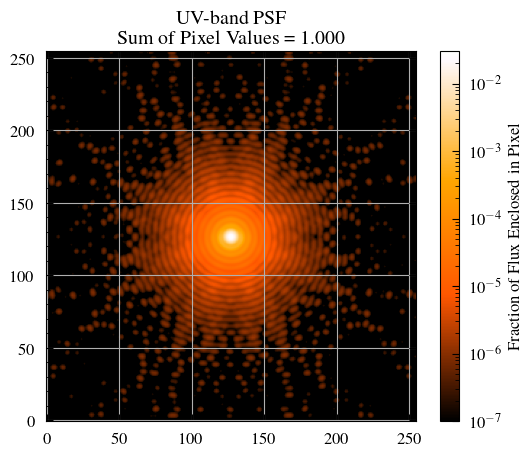

/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/data/psfs/Usamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits


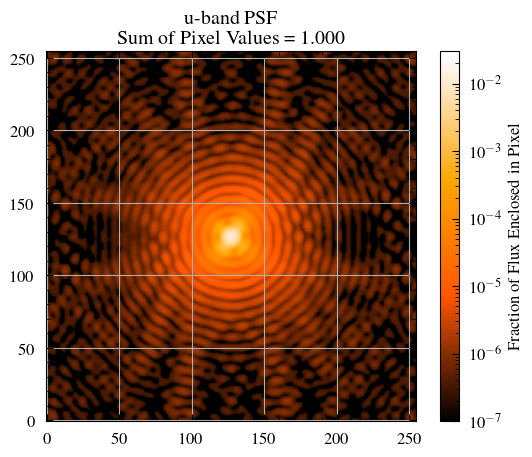

/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/data/psfs/Gsamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits


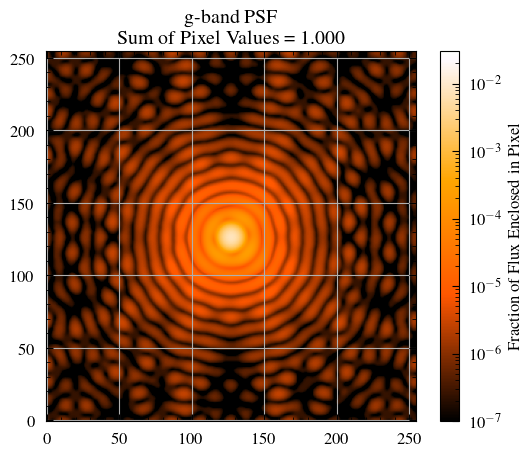

In [4]:
for psf_file, passband in zip(psf_files, psf_passbands):
    print(psf_file)
    psf = fits.getdata(psf_file)
    fig, ax = plt.subplots()
    img = ax.imshow(
        psf, origin="lower", cmap=ds9heat_cmap, norm=LogNorm(vmin=1e-7, vmax=0.03)
    )  # no need to transpose. Same result as DS9
    cbar = fig.colorbar(img)
    cbar.set_label("Fraction of Flux Enclosed in Pixel")
    ax.set_title(f"{passband}-band PSF\nSum of Pixel Values = {np.sum(psf):.3f}")
    plt.show()

Use `RegularGridInterpolator` to create an even higher resolution of the PSFs.
Specifically, we will create a PSF that is sampled at 20x the telescope's resolution by
interpolating to a grid that is twice as fine as the grid in the PSF file.

In [5]:
MyTelescope = Telescope()  # default telescope parameters
psf_resolution = MyTelescope.px_scale.to(u.arcsec).value / SUPERSAMPLE_FACTOR

new_psf_files = []  # to store new PSF filenames
for psf_file, passband in zip(psf_files, psf_passbands):
    psf = fits.getdata(psf_file)
    #
    # Original PSF grid
    #
    xlim = 0.5 * psf.shape[1] * psf_resolution
    ylim = 0.5 * psf.shape[0] * psf_resolution
    xvals = np.arange(-xlim + 0.5 * psf_resolution, xlim, psf_resolution)
    yvals = np.arange(-ylim + 0.5 * psf_resolution, ylim, psf_resolution)
    xgrid, ygrid = np.meshgrid(xvals, yvals)
    #
    # Make interpolator
    #
    psf_interp = RegularGridInterpolator(
        (xvals, yvals), psf, method="linear", bounds_error=True, fill_value=np.nan
    )
    #
    # Find values at finer grid
    #
    new_xvals = np.arange(xvals.min(), xvals.max(), 0.5 * psf_resolution)
    new_yvals = np.arange(yvals.min(), yvals.max(), 0.5 * psf_resolution)
    new_xgrid, new_ygrid = np.meshgrid(new_xvals, new_yvals, indexing="ij")
    new_psf = (
        psf_interp((new_xgrid, new_ygrid)) * 0.25
    )  # each pixel is 4x smaller, flux scales with area
    print(
        f"Any non-finite values in new {passband}-band PSF?",
        np.any(~np.isfinite(new_psf)),
    )
    #
    # Export to FITS file
    #
    hdu = fits.PrimaryHDU(new_psf)
    new_psf_filename = f"{passband.lower()}_psf_20x_supersampled.fits"
    new_psf_files.append(new_psf_filename)
    hdu.writeto(new_psf_filename, overwrite=True)
    print("Saved", new_psf_filename)
    print()

Any non-finite values in new UV-band PSF? False
Saved uv_psf_20x_supersampled.fits

Any non-finite values in new u-band PSF? False
Saved u_psf_20x_supersampled.fits

Any non-finite values in new g-band PSF? False
Saved g_psf_20x_supersampled.fits



Check HDU list and header of new PSF FITS files and plot them

Filename: uv_psf_20x_supersampled.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (509, 509)   float64   
None


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  509                                                  
NAXIS2  =                  509                                                  
EXTEND  =                    T                                                  

Number of pixels <= 0: 27643
Number of pixels < 0: 27643
Sum of pixels <= 0: -4.863309664095742e-07


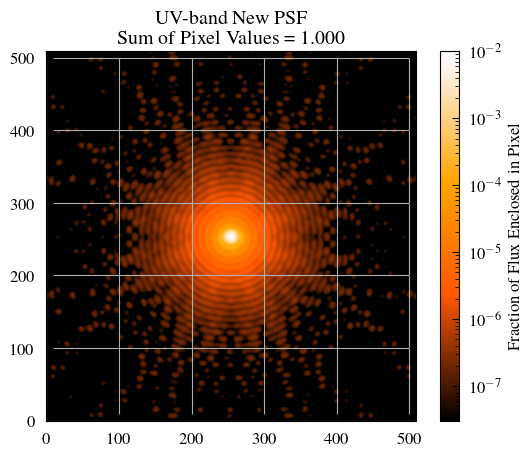

Filename: u_psf_20x_supersampled.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (509, 509)   float64   
None


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  509                                                  
NAXIS2  =                  509                                                  
EXTEND  =                    T                                                  

Number of pixels <= 0: 167
Number of pixels < 0: 167
Sum of pixels <= 0: -2.1535847398139875e-08


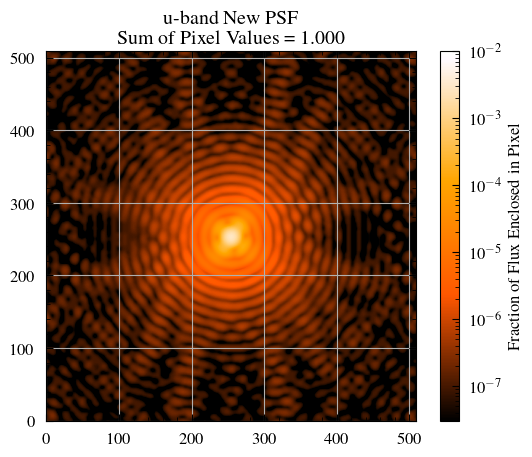

Filename: g_psf_20x_supersampled.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (509, 509)   float64   
None


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  509                                                  
NAXIS2  =                  509                                                  
EXTEND  =                    T                                                  

Number of pixels <= 0: 67
Number of pixels < 0: 67
Sum of pixels <= 0: -2.3144313406383716e-10


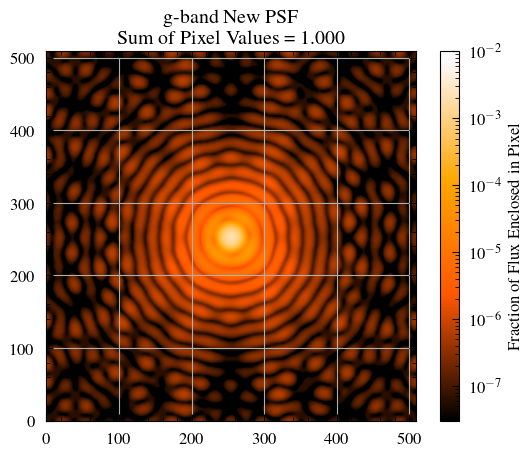

In [6]:
for new_psf_file, passband in zip(new_psf_files, psf_passbands):
    with open(new_psf_file, "rb") as f:
        hdul = fits.open(f)
        print(hdul.info())
        display(hdul[0].header)
        new_psf = hdul[0].data
    print("Number of pixels <= 0:", np.sum(new_psf <= 0))
    print("Number of pixels < 0:", np.sum(new_psf < 0))
    print("Sum of pixels <= 0:", np.sum(new_psf[new_psf <= 0]))
    fig, ax = plt.subplots()
    img = ax.imshow(
        new_psf, origin="lower", cmap=ds9heat_cmap, norm=LogNorm(vmin=3e-8, vmax=0.01)
    )  # no need to transpose. Same result as DS9
    cbar = fig.colorbar(img)
    cbar.set_label("Fraction of Flux Enclosed in Pixel")
    ax.set_title(f"{passband}-band New PSF\nSum of Pixel Values = {np.sum(new_psf):.3f}")
    plt.show()